In [61]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model, Sequential

from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils import shuffle

from hyperas.distributions import choice, uniform

In [3]:
data = pd.read_csv('../../task2_data/task2_en_training.tsv',delimiter='\t')[['class', 'tweet']]

X_train = data['tweet']
y_train = data['class']

Xy = pd.concat([X_train, y_train], axis=1)

# paramters of the text praprations
n_train = 500
n_test  = 200

df_1 = Xy[Xy['class'] == 1].iloc[:n_train] 
df_0 = Xy[Xy['class'] == 0].iloc[:n_train] 
Xy_ = shuffle(pd.concat([df_0, df_1]))
Xy_train = pd.concat([Xy_["tweet"], Xy_["class"]], axis = 1)


df_1 = Xy[Xy['class'] == 1].iloc[n_train:n_train+n_test]
df_0 = Xy[Xy['class'] == 0].iloc[n_train:n_train+n_test]
Xy_ = shuffle(pd.concat([df_0, df_1]))
Xy_test = pd.concat([Xy_["tweet"], Xy_["class"]], axis = 1)

print(Xy_train.shape)
print(Xy_test.shape)

(1000, 2)
(400, 2)


In [4]:
train_texts = Xy_train['tweet'].values
train_texts = [s.lower() for s in train_texts]

test_texts = Xy_test['tweet'].values
test_texts = [s.lower() for s in test_texts]

# ====================================================
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(train_texts)
tk.word_index = char_dict.copy()
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

#=====================================================

train_sequences = tk.texts_to_sequences(train_texts)
test_texts = tk.texts_to_sequences(test_texts)

# Padding
train_data = pad_sequences(train_sequences, maxlen=200, padding='post')
test_data = pad_sequences(test_texts, maxlen=200, padding='post')

# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

train_data.shape, test_data.shape

((1000, 200), (400, 200))

In [5]:
pd.DataFrame(train_data)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,4.0,5.0,16.0,1.0,11.0,15.0,20.0,5.0,69.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.0,69.0,19.0,23.0,5.0,1.0,18.0,69.0,20.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,25.0,69.0,23.0,9.0,6.0,5.0,69.0,23.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,49.0,8.0,15.0,16.0,9.0,14.0,7.0,6.0,15.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49.0,5.0,16.0,9.0,1.0,23.0,1.0,18.0,5.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,26.0,15.0,12.0,15.0,6.0,20.0,69.0,54.0,1.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,49.0,1.0,17.0,21.0,1.0,6.0,1.0,18.0,5.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,49.0,4.0,18.0,15.0,26.0,69.0,9.0,69.0,20.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,1.0,8.0,69.0,3.0,18.0,1.0,16.0,37.0,69.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_classes = Xy_train['class'].values
train_class_list = [x for x in train_classes]

test_classes = Xy_test['class'].values
test_class_list = [x for x in test_classes]

from keras.utils import to_categorical

train_classes = to_categorical(train_class_list)
test_classes = to_categorical(test_class_list)

#train_classes.shape, test_classes.shape

In [7]:
char_vocab = len(tk.word_index)

In [8]:
embedding_weights = []
embedding_weights.append(np.zeros(char_vocab))

for char, i in tk.word_index.items():
    onehot = np.zeros(char_vocab)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)

#print(embedding_weights.shape)
#embedding_weights

In [9]:
input_size = train_data.shape[1]
embedding_size = embedding_weights.shape[1]

conv_layers = [[256,7, 3],
               [256,7, 3],
               [256,7, -1],
               [256,7, 3]] #filter_num, filter_size, pooling_size

fully_connected_layers = [200, 200] 
num_of_classes = 2
dropout_p = 0.5
optimizer = 'rmsprop'
loss = 'binary_crossentropy'

input_size, char_vocab

(200, 69)

In [10]:
embedding_layer = Embedding(char_vocab+1,
                           embedding_size,
                           input_length=input_size,
                           weights=[embedding_weights])

In [63]:
inputs = Input(shape=(input_size,), name='input', dtype='int64')

x = embedding_layer(inputs)

for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x)
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)

x = Flatten()(x)


x = Dense((dense_size), activation='relu')(x)
x = Dropout(dropout_p)(x)
x = Dense(dense_size, activation='relu')(x)
x = Dropout(dropout_p)(x)
    
predictions = Dense(num_of_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 69)           4830      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 194, 256)          123904    
_________________________________________________________________
activation_46 (Activation)   (None, 194, 256)          0         
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 64, 256)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 58, 256)           459008    
_________________________________________________________________
activation_47 (Activation)   (None, 58, 256)           0   

In [9]:
dense_size

NameError: name 'dense_size' is not defined

In [12]:
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)

x_train = train_data[indices]
y_train = train_classes[indices]

x_test = test_data
y_test = test_classes

x_train

array([[18., 20., 69., ...,  0.,  0.,  0.],
       [ 5., 24.,  3., ...,  0.,  0.,  0.],
       [ 3., 15., 59., ...,  0.,  0.,  0.],
       ...,
       [18., 20., 69., ...,  0.,  0.,  0.],
       [49.,  2., 21., ...,  0.,  0.,  0.],
       [ 9., 69.,  4., ...,  0.,  0.,  0.]], dtype=float32)

In [13]:
STAMP = 'CNN_charLvl'

early_stopping =   EarlyStopping(monitor='val_loss', patience=20)
bst_model_path =   STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

history = model.fit(x_train, y_train,
                    validation_data=(x_test[:100], y_test[:100]),
                    batch_size=32,
                    epochs=100,
                    shuffle=True,
                    callbacks=[early_stopping, model_checkpoint])

/home/alexkay/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1000 samples, validate on 100 samples
Epoch 1/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7093 - accuracy: 0.5030 - val_loss: 0.6918 - val_accuracy: 0.5400
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6951 - accuracy: 0.5050 - val_loss: 0.6888 - val_accuracy: 0.6300
Epoch 3/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6935 - accuracy: 0.5190 - val_loss: 0.8524 - val_accuracy: 0.4600
Epoch 4/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6981 - accuracy: 0.5630 - val_loss: 1.2147 - val_accuracy: 0.4900
Epoch 5/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6948 - accuracy: 0.6010 - val_loss: 0.6655 - val_accuracy: 0.5600
Epoch 6/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6576 - accuracy: 0.6480 - val_loss: 0.7470 - val_accuracy: 0.5900
Epoch 7/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5769

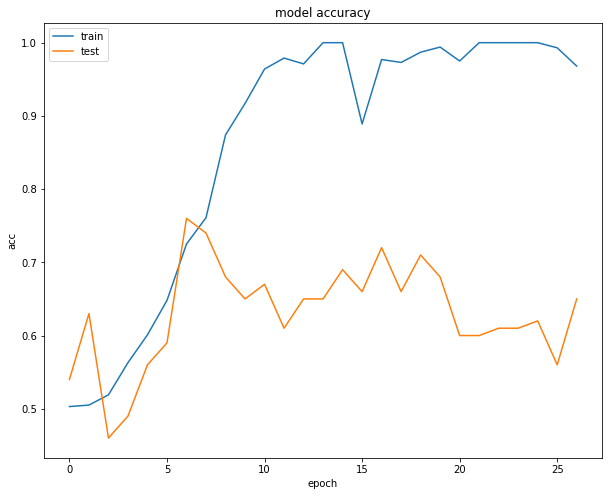

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) 

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [15]:
pred = model.predict(x_test[100:])

In [16]:
pred = model.predict(x_test[100:])
pred.shape
bin_pred, real = [], np.array(Xy_test["class"]).tolist()[n_test//2:]

for i in range(len(pred)):
    #print(f'pred = {int(round(float(pred[i][0]), 0))},\t real = {real[i]}')
    bin_pred.append(int(round(float(pred[i][0]), 0))) 
#np.array(Xy_test["class"]).tolist()
bin_pred, real

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(real, bin_pred))
pd.DataFrame(confusion_matrix(real, bin_pred), columns=['Pos', 'Neg'])

              precision    recall  f1-score   support

           0       0.32      0.34      0.33       146
           1       0.35      0.34      0.34       154

    accuracy                           0.34       300
   macro avg       0.34      0.34      0.34       300
weighted avg       0.34      0.34      0.34       300



,Pos,Neg
0,49,97
1,102,52
